In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

In [98]:
# 1. Dataset: température et vent → choix entre Veste ou t-shirt
np.random.seed(42)
n_samples = 200

# Température entre 0°C et 35°C, vent entre 0 et 50 km/h
temperatures = np.random.randint(0, 36, n_samples)
vents = np.random.randint(0, 51, n_samples)

# Règles pour le choix du vêtement
vetements = []
for temp, vent in zip(temperatures, vents):
    if temp < 15:
        vetement = 'Veste'
    elif temp > 25:
        vetement = 't-shirt'
    else:
        vetement = 'Veste' if vent > 30 else 't-shirt'
    vetements.append(vetement)

df = pd.DataFrame({'temperature': temperatures, 'vent': vents, 'vetement': vetements})
print(f"Dataset: {len(df)} exemples")
df.head()

Dataset: 200 exemples


,temperature,vent,vetement
0,28,6,t-shirt
1,14,15,Veste
2,7,25,Veste
3,20,47,Veste
4,18,48,Veste


In [99]:
# 2. Séparation et entraînement
X = df[['temperature', 'vent']]
Y = df['vetement']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [ ]:
# 3. Creation du modele
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, Y_train)

print(f"Train: {X_train.shape}")

Train: (140, 2), Test: (60, 2)


In [101]:
# 4. Évaluation
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f"Précision: {accuracy:.2%}\n")
print(classification_report(Y_test, Y_pred))

Précision: 100.00%

              precision    recall  f1-score   support

       Veste       1.00      1.00      1.00        31
     t-shirt       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [102]:
# 5. Test sur exemples fictifs
exemples = pd.DataFrame([
    [5, 40],    # Froid et venteux
    [30, 10],   # Chaud et calme
    [20, 25],   # Zone ambiguë
    [15, 35],   # Venteux
], columns=['temperature', 'vent'])

predictions = clf.predict(exemples)
for i, pred in enumerate(predictions):
    print(f"Temp={exemples.iloc[i]['temperature']}°C, Vent={exemples.iloc[i]['vent']}km/h → {pred}")

Temp=5°C, Vent=40km/h → Veste
Temp=30°C, Vent=10km/h → t-shirt
Temp=20°C, Vent=25km/h → t-shirt
Temp=15°C, Vent=35km/h → Veste


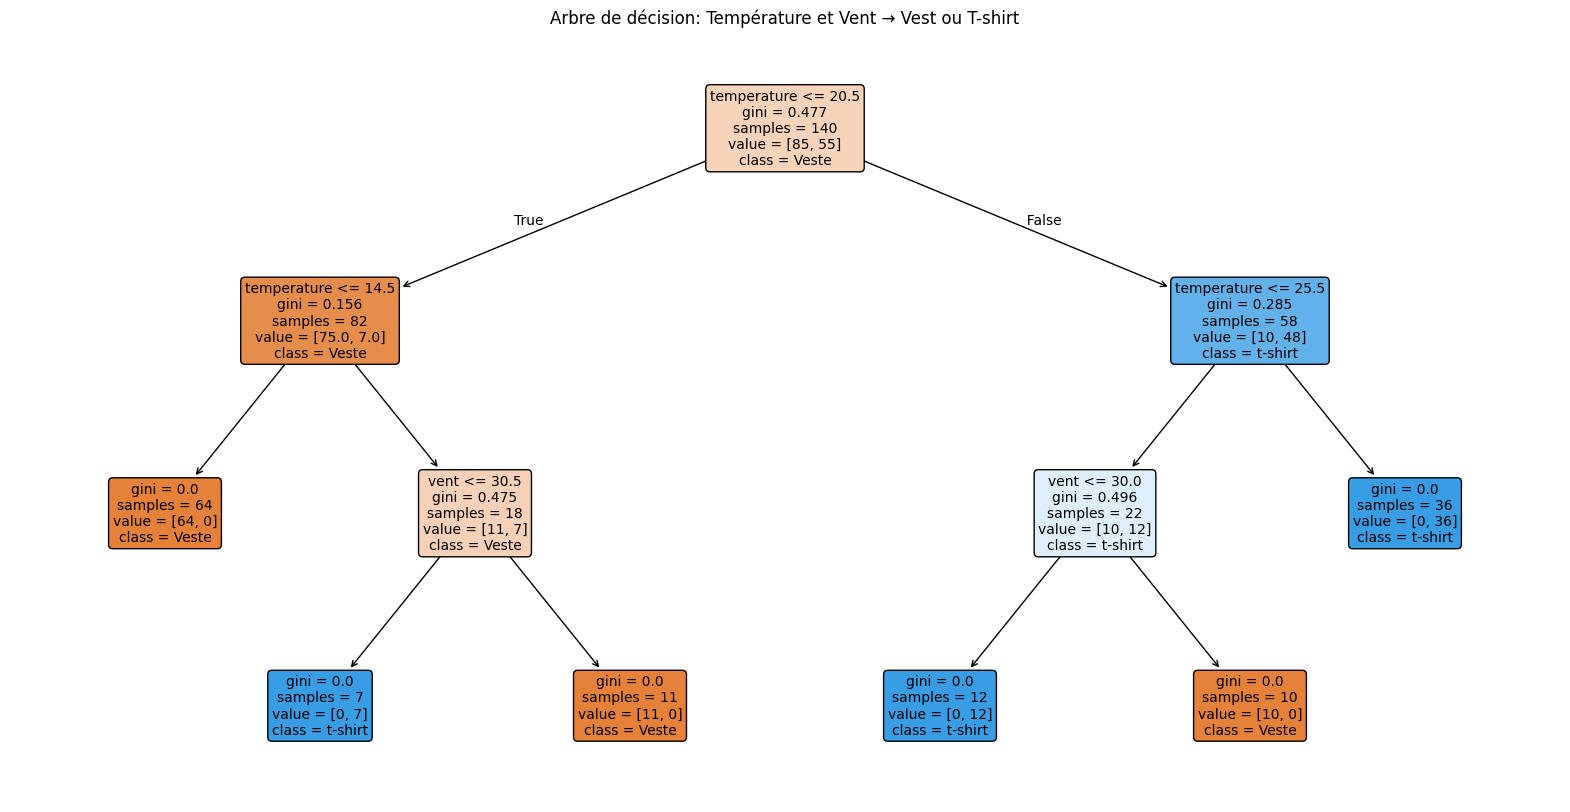

In [103]:
# 5. Visualisation de l'arbre de décision
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True, fontsize=10)
plt.title("Arbre de décision: Température et Vent → Vest ou T-shirt")
plt.show()